In [1]:
# importing of standard libraries
from cs103 import *
from typing import NamedTuple, List
import csv
import matplotlib.pyplot as plt
import numpy as np

# Project Final Submission
### Step 1a: Identify the information in the file your program will read

The file coord.csv containts the following data:

+ Simulation options chosen (which is ignored since they don't have anything to add to our data analysis)
+ Time ($t$) (in picoseconds) of when the "frame" was taken
+ Position of atom in 3D coordinate space:
    + x-direction ( $x$ )
    + y-direction ( $y$ )
    + z-direction ( $z$ )
+ Velocity of atom in 3D coordinate space:
    + Velocity x-direction ( $V_x$ ) 
    + Velocity y-direction ( $V_y$ )
    + Velocity z-direction ( $V_z$ )
    
Example of the structure of the data

| $t=0$ |   |   |    |    |    |
|------|:----:|----:|----|----|----|
| $x$    | $y$ | $z$ | $V_x$ | $V_y$ | $V_z$ |
| $x$    | $y$ | $z$ | $V_x$ | $V_y$ | $V_z$ |
| $x$    | $y$ | $z$ | $V_x$ | $V_y$ | $V_z$ |

| $t=1$ |   |   |    |    |    |
|------|:----:|----:|----|----|----|
| $x$    | $y$ | $z$ | $V_x$ | $V_y$ | $V_z$ |
| $x$    | $y$ | $z$ | $V_x$ | $V_y$ | $V_z$ |
| $x$    | $y$ | $z$ | $V_x$ | $V_y$ | $V_z$ |

Here there are 2 "frames" where the information of the atoms were recorded (frame at $t=0$ and $t=1$. Each row of x,y,z represents an atom in the specified time frame "snapshot".

For my analysis program, I will only be focusing on the velocities (x, y and z directions) and time. Positions of the atoms will be not be used in my analysis program.

### Step 1b: Write a description of what your program will produce

    1) My program could calculate to kinetic energy of the simulation throughout time
    
    or

    2) My program could make a velocity autocorrelation plot (VACF) by following one atom throughout different time frames and take the dot product of the velocity.
    
    or
    
    3) My program will calculate the average momentum of the system throughout time

### Step 1c: Write or draw examples of what your program will produce

Write or draw examples of what your program will produce.

    make_kinetic_plot(loc: List[Coord])

    where this function gives a kinetic energy over time plot.
    
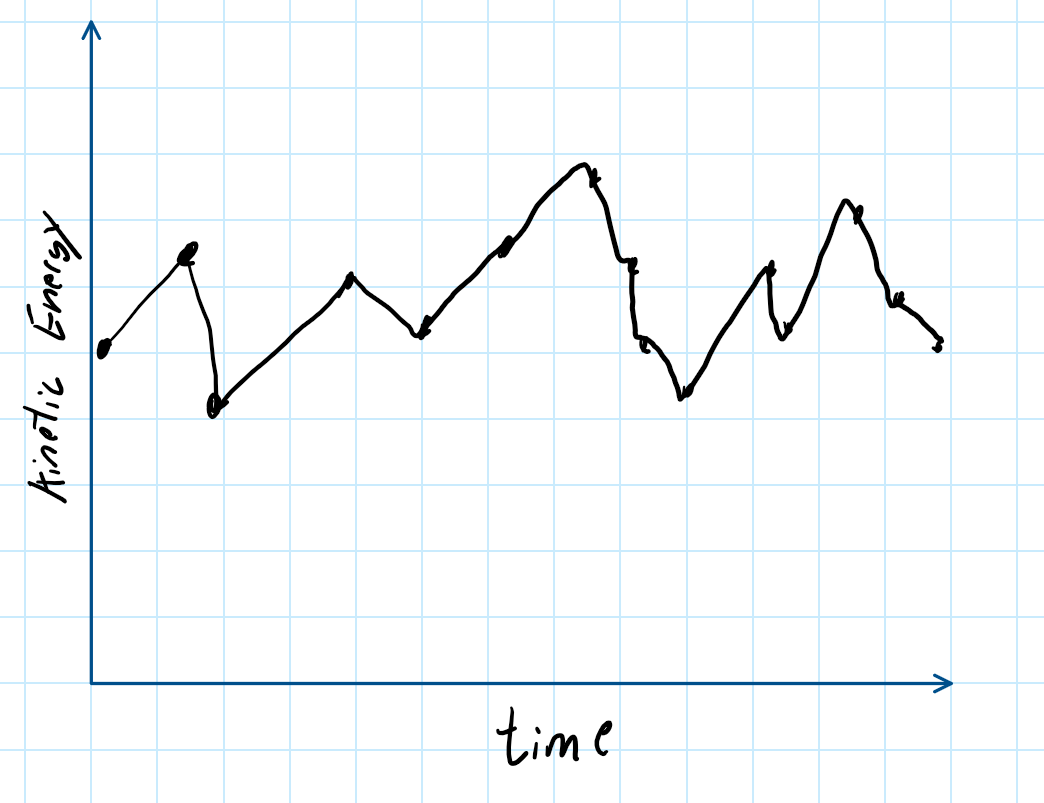

    or
    
    make_vacf_plot(loc: List[Coord])
    
    where this function gives a velocity autocorrelation function over time plot which looks like ...
    
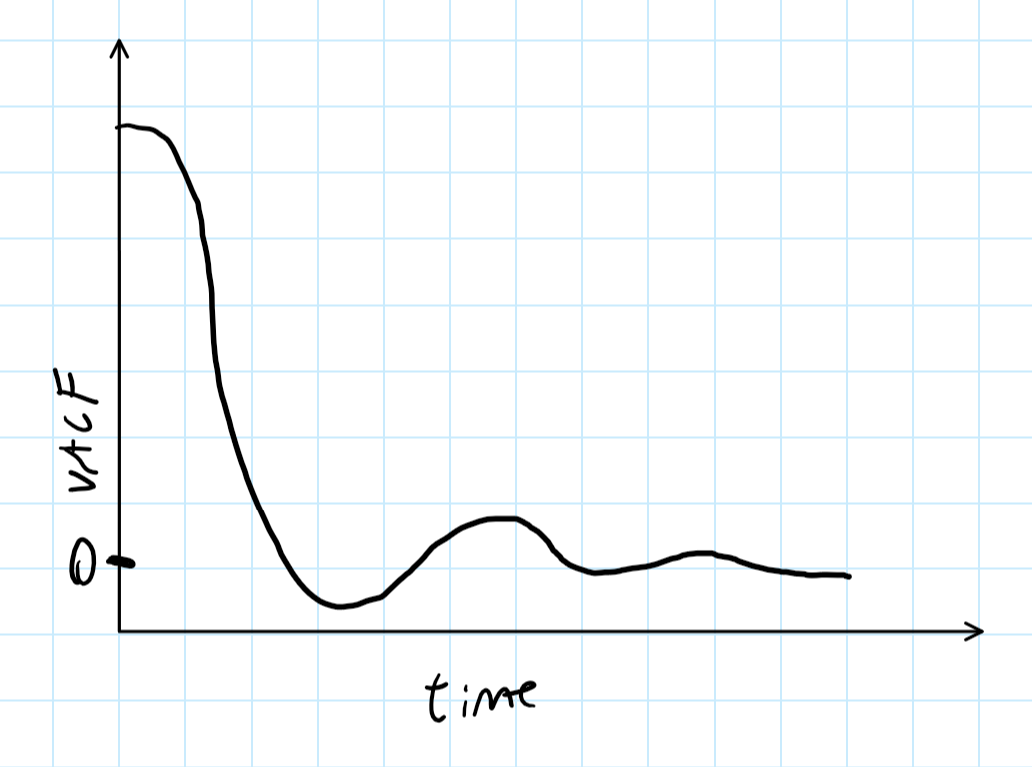
    
    or
    
    make_momentum_plot(loc: List[Coord])
    
    where this function gives a system momentum over time plot which looks like ...
    
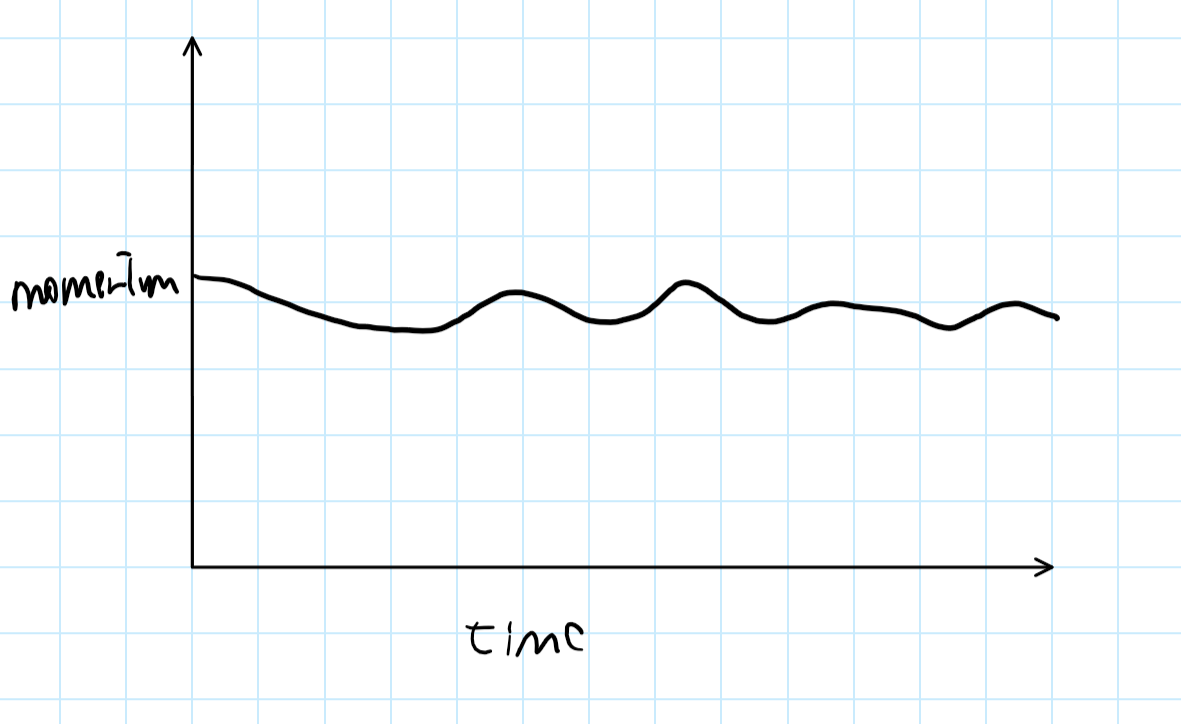

### Step 2a: Design data definitions



   For my functions to work, I will need to to store the atom's velocity (in the x,y,z directions), the timeframe which this data is collected, and the atom number to easily identify which atom in the timeframe we are looking at. The velocity of the atoms is needed to determine the kinetic energy, momentum, and the velocity correlation function. Since all of these plots are done against time, I will need a way to keep track of what timeframe each line being read belongs to. I will also need to implement a way to label the atoms with a number so they can be followed through time to make an VACF plot.


In [2]:
#---------DATA DEFINITIONS-------


Coord = NamedTuple('Coord', [('time', float),       # in range [0, ...]
                             ('atom', int),         # in range [0, ...]
                             ('vx', float),         # in range [-inf, +inf]
                             ('vy', float),         # in range [-inf, +inf]
                             ('vz', float)])        # in range [-inf, +inf]

#interp. Coordinate consiting of its given timeframe (float), atom number (int), velocity-x direction (vx, float),
#velocity-y direction (vy, float) and velocity-z direction (vz, float)

#examples 
@typecheck
def fn_for_coord(c: Coord)-> ...:           #template based on compound data
    return ...(c.time,
               c.atom,
               c.vx,
               c.vy,
               c.vz)

# examples
C0 = Coord(0.0, 1, 0.1, -0.34, -3.04)
C1 = Coord(0.9, 10, -0.142, -1.34, 3.98)
C2 = Coord(1.4, 6, 0.1323, -2.34, -93.04)
C3 = Coord(0.0, 123, 0.13, -1.34, -399.04)


#List[Coord]
#interp. a list of coordinates (Coord)

#examples
LOC0 = []
LOC1 = [C0]
LOC2 = [C0, C1]
LOC3 = [C1, C2, C3]
LOC4 = [C0, C1, C2, C3]


@typecheck
def fn_for_loc(loc: List[Coord])-> ...:
    #template based on arbitrary sized data with reference rule
    
    #description of accumulator
    acc = ... #type: ...
    
    for c in loc:
        acc = ...(c)
    
    return ...(acc)
    

### Step 2b: Design a function to read the information and store it as data in your program

Read function I made includes 2 extra functionalities.

    1) It keeps track of which timeframe the line being read belongs to
    2) It numbers each to atom with its respective line 

In [3]:
#--------------Read function---------------------------------------


@typecheck
def read(filename: str)-> List[Coord]:
    """
    reads into a specified coordinate csv file, skips the first 9 lines of the file. It begins by checking if
    the line being read is 'time' by using the is_time function. If the line being read is time, it is recorded
    and all of the lines following it are recorded as a Coord type with the recorded time. Once the file
    reader reaches the next time step with the is_time function, the new time is recorded for the coordinates
    following it. Whenever the next timeframe is being read, atom_label resets, so the corresponding line that
    is being read into is kept as (1,2,3,4....) until all atoms are accounted for in that timeframe.
    
    """
    
    # return [] #stub
    # Template from HtDAP
    # loc contains the list of coordinats in the file seen so far
    # time_frame stores the current timeframe which atom is being read belongs to
    # atom_label contains atom number identifier
    
    loc = [] #type: List[Coord]
    time_frame = 0 #type: float
    atom_label = 0 #type: int
    
    with open(filename) as csvfile:
        reader = csv.reader(csvfile)
        
        for i in range(0,9):
            next(reader) # skips header line + simulation parameters
        
        for row in reader:
            atom_label += 1                             #changes atom number/label for next line
            if is_time(row[1], row[2]):                 #checks if line being read is a time frame
                time_frame = parse_float(row[0])        #stores time for use in atoms in this specified time frame
                atom_label = 0                          #resets atom number for next timeframe
            else:
                loc.append(Coord(time_frame, 
                                 atom_label, 
                                 parse_float(row[3]),
                                 parse_float(row[4]),
                                 parse_float(row[5])))
                
    return loc


#--------------Helper functions---------------------------------------

@typecheck
def is_time(s: str, s2: str)-> bool:
    """
    Checks if line being read is a time by seeing if the s or s2 is an empty string. 
    """
    # return True #stub
    # template based on atomic non-disntinct
    if s == '' and s2 == '':
        return True
    else:
        return False
    
    
#-------------Testing----------------------------------------------

# Testing of is_time Function
start_testing()
expect(is_time('',''), True)
expect(is_time('something',''), False)
expect(is_time('','a'), False)
summary()

# Testing of read function
start_testing()
expect(read('small_test.csv'), [Coord(0.0, 1, -1.25474, 0.289219, 0.0250124),
                                Coord(0.0, 2, -0.227495, -1.08539, -0.518909),
                                Coord(0.0, 3, 0.479134, -0.806718, 0.0722117),
                                Coord(0.0, 4, 0.789996, -0.496801, 1.4041),
                                Coord(0.999999, 1, -1.25772, 0.287784, 0.0281068),
                                Coord(0.999999, 2, 0.0233178, -0.849291, -0.54138),
                                Coord(0.999999, 3, 0.513885, -0.808728, 0.123245),
                                Coord(0.999999, 4, 0.755004, -0.49473, 1.35312),
                                Coord(2.0, 1, -1.1847, 0.199981, -0.0498379),
                                Coord(2.0, 2, -0.0534537, -0.763726, -0.45987),
                                Coord(2.0, 3, 0.603445, -0.789527, 0.319321),
                                Coord(2.0, 4, 0.665445, -0.513931, 1.15704)])
expect(read('smaller.csv'), [Coord(0.0, 1, -1.25474, 0.289219, 0.0250124),
                                Coord(0.0, 2, -0.227495, -1.08539, -0.518909),
                                Coord(0.999999, 1, -1.25772, 0.287784, 0.0281068),
                                Coord(0.999999, 2, 0.0233178, -0.849291, -0.54138),
                                Coord(2.0, 1, -1.1847, 0.199981, -0.0498379),
                                Coord(2.0, 2, -0.0534537, -0.763726, -0.45987)])
summary()

3 of 3 tests passed
2 of 2 tests passed


### Step 2b and 2c: Building
#### Design a function to read the information and store it as data in your program
#### Design functions to analyze the data


Complete these steps in the code cell below. You will likely want to rename the analyze function so that the function name describes what your analysis function does.

In [4]:
@typecheck
def get_kinetic(loc: List[Coord])->List[float]:
    """
    function takes in a List of coordinates and calculates the kinetic energy sum of all of the atom at
    a specific time for each time step. ASSUMES LIST IS NOT EMPTY
    """
    # return [] # stub
    # Template based on List[Coord] and reference rule
    # Accumulator is the kinetic energy of the system at a given time seen so far
    
    lok = [] #Type: List[float]
    kinetic = 0                            #Type: float, used to temporary store kinetic energy
    atoms = count_atoms(loc)               #Type: int, used to store the number of atoms in the system
    atom_count = 0                         #Type: int, used to store the number of atoms seen so far
    
    for c in loc:
        kinetic += kinetic_calculation(c)            #function calculates kinetic energy for given atom
        atom_count +=1                               #moves the atom count for next atom
        
        if atom_count == atoms:                      #this section checks if all atoms have been accounted. for
                                                     #at a given time instance, saves the kinetic energy
                                                     #and then resets the kinetic
                                                     #energy and atom count for next time step
            lok.append(kinetic)
            kinetic = 0
            atom_count = 0
            
    return lok

@typecheck
def get_time(loc: List[Coord])->List[float]:
    """
    function gets the a list of times for the simulation list of coordinates
    with no repeats. (i.e [0.0, 0.0, 1.1, 1.1, 2.2, 2.2] becomes [0.0, 1.1, 2.2])
    """
    #return [] #stub
    #template based on List[Coord]
    #accumulator is the list of times seen so far (with no repeats)
    
    lot = [] #type: List[float]
    prev_time = -1
    
    for c in loc:
        if prev_time < c.time:
            lot.append(c.time)
            prev_time = c.time
        
    return lot

@typecheck
def kinetic_calculation(c: Coord)->float:
    """
    function takes a Coordinate type and calculates the kinetic energy for the given coordinate by using
    (1/2)*mv**2 for all dimensions (x,y,z)
    """
    # return 1.2
    # template based on arbitary-sized data (of Coord definition)
    
    energy = 0.5*300*(c.vx**2+c.vy**2+c.vz**2)
    return energy
    
@typecheck
def count_atoms(loc: List[Coord])->int:
    """
    takes any list of coordinates and determines how many atoms there are in a given time
    """
    #return 3 #stub
    #template based on List[Coord]
    # acummulator is atom numbers seen so far
    
    loa = [] #type: List[int]
    
    for c in loc:
        loa.append(c.atom)
        
    return max(loa)


In [5]:
# Helper Function Testing

# ALL FUNCTIONS ASSUME LISTS ARE NON EMPTY

# testing of count_atoms
start_testing()
expect(count_atoms([Coord(0.0, 1, -1.25474, 0.289219, 0.0250124),
                    Coord(0.0, 2, -0.227495, -1.08539, -0.518909),
                    Coord(0.999999, 1, -1.25772, 0.287784, 0.0281068),
                    Coord(0.999999, 2, 0.0233178, -0.849291, -0.54138),
                    Coord(2.0, 1, -1.1847, 0.199981, -0.0498379),
                    Coord(2.0, 2, -0.0534537, -0.763726, -0.45987)]), 2)
expect(count_atoms([Coord(0.0, 1, -1.25474, 0.289219, 0.0250124),
                    Coord(0.999999, 1, -1.25772, 0.287784, 0.0281068),
                    Coord(2.0, 1, -1.1847, 0.199981, -0.0498379)]), 1)
expect(count_atoms(read('test.csv')),120)
summary()



# testing of kinetic_calculation
start_testing()
expect(kinetic_calculation(Coord(0.0, 1, -1.25474, 0.289219, 0.0250124)),
                           0.5*300*((-1.25474)**2+(0.289219)**2+(0.0250124)**2))
expect(kinetic_calculation(Coord(0.0, 1, 0, 0, 0)),
                           0.5*300*((0)**2+(0)**2+(0)**2))
expect(kinetic_calculation(Coord(0.3, 23, 1000, -1000, 0)),
                           0.5*300*((1000)**2+(-1000)**2+(0)**2))
summary()



# testing of get_time
start_testing()
expect(get_time([Coord(0.0, 1, -1.25474, 0.289219, 0.0250124),
                Coord(0.0, 2, -0.227495, -1.08539, -0.518909),
                Coord(0.999999, 1, -1.25772, 0.287784, 0.0281068),
                Coord(0.999999, 2, 0.0233178, -0.849291, -0.54138),
                Coord(2.0, 1, -1.1847, 0.199981, -0.0498379),
                Coord(2.0, 2, -0.0534537, -0.763726, -0.45987)]), [0.0, 0.999999, 2.0])
expect(get_time([Coord(0.0, 1, -1.25474, 0.289219, 0.0250124),
                Coord(0.0, 2, -0.227495, -1.08539, -0.518909),
                Coord(0.0, 3, 0.479134, -0.806718, 0.0722117),
                Coord(0.0, 4, 0.789996, -0.496801, 1.4041),
                Coord(0.999999, 1, -1.25772, 0.287784, 0.0281068),
                Coord(0.999999, 2, 0.0233178, -0.849291, -0.54138),
                Coord(0.999999, 3, 0.513885, -0.808728, 0.123245),
                Coord(0.999999, 4, 0.755004, -0.49473, 1.35312),
                Coord(2.0, 1, -1.1847, 0.199981, -0.0498379),
                Coord(2.0, 2, -0.0534537, -0.763726, -0.45987),
                Coord(2.0, 3, 0.603445, -0.789527, 0.319321),
                Coord(2.0, 4, 0.665445, -0.513931, 1.15704)]), [0.0, 0.999999, 2.0])
expect(get_time([Coord(0.1, 1, -1.25474, 0.289219, 0.0250124),
                Coord(0.1, 2, -0.227495, -1.08539, -0.518909),
                Coord(0.2, 1, -1.25772, 0.287784, 0.0281068),
                Coord(0.2, 2, 0.0233178, -0.849291, -0.54138),
                Coord(2.0, 1, -1.1847, 0.199981, -0.0498379),
                Coord(2.0, 2, -0.0534537, -0.763726, -0.45987)]), [0.1, 0.2, 2.0])
summary()

# testing of get_kinetic, expected values are calculated from excel to check for consistency
start_testing()
expect(get_kinetic([Coord(0.0, 1, -1.25474, 0.289219, 0.0250124),
                    Coord(0.0, 2, -0.227495, -1.08539, -0.518909),
                    Coord(0.0, 3, 0.479134, -0.806718, 0.0722117),
                    Coord(0.0, 4, 0.789996, -0.496801, 1.4041),
                    Coord(0.999999, 1, -1.25772, 0.287784, 0.0281068),
                    Coord(0.999999, 2, 0.0233178, -0.849291, -0.54138),
                    Coord(0.999999, 3, 0.513885, -0.808728, 0.123245),
                    Coord(0.999999, 4, 0.755004, -0.49473, 1.35312),
                    Coord(2.0, 1, -1.1847, 0.199981, -0.0498379),
                    Coord(2.0, 2, -0.0534537, -0.763726, -0.45987),
                    Coord(2.0, 3, 0.603445, -0.789527, 0.319321),
                    Coord(2.0, 4, 0.665445, -0.513931, 1.15704)]), [1032.8575904751974, 938.9146645035121, 806.8130639757151])
expect(get_kinetic([Coord(0.0, 1, -1.25474, 0.289219, 0.0250124),
                    Coord(0.0, 2, -0.227495, -1.08539, -0.518909),
                    Coord(0.0, 3, 0.479134, -0.806718, 0.0722117),
                    Coord(0.999999, 1, -1.25772, 0.287784, 0.0281068),
                    Coord(0.999999, 2, 0.0233178, -0.849291, -0.54138),
                    Coord(0.999999, 3, 0.513885, -0.808728, 0.123245),
                    Coord(2.0, 1, -1.1847, 0.199981, -0.0498379),
                    Coord(2.0, 2, -0.0534537, -0.763726, -0.45987),
                    Coord(2.0, 3, 0.603445, -0.789527, 0.319321)]), [606.4973319326475, 542.056282406112, 499.9605116178151])
summary()

3 of 3 tests passed
3 of 3 tests passed
3 of 3 tests passed
2 of 2 tests passed


In [6]:
# getting momentum information

def get_momentum(loc: List[Coord])->List[float]:
    """
    function takes in a List of coordinates and calculates the momentum sum of all of the atoms at
    a specific time for each time step. ASSUMES LIST IS NOT EMPTY
    """
    # return [] # stub
    # Template based on on List[Coord] and reference rule
    # Accumulator is the kinetic energy of the system at a given time seen so far
    
    lom = [] #Type: List[float]
    momentum = 0                        #Type: float, holds the momentum summed up so far for a timestep
    atoms = count_atoms(loc)            #Type: int, used to store the number of atoms in the system
    atom_count = 0                      #Type: int, used to store the number of atoms seen so far
    
    for c in loc:
        momentum += momentum_calculation(c)/atoms       #function calculates momentum for given atom
        atom_count +=1                                  #moves atom counter for next atom
        
        if atom_count == atoms:                      #this section checks if all atoms have been accounted. for
                                                     #at a given time instance, saves momentum
                                                     #and then resets the momentum
                                                     #and atom count for next time step
            lom.append(momentum)
            momentum = 0
            atom_count = 0
    return lom

@typecheck
def momentum_calculation(c: Coord)->float:
    """
    function takes a Coordinate type and calculates the kinetic energy for the given coordinate by using
    1/2 mv**2
    """
    # return 1.2 #stub
    # template based on arbitary-sized data (of Coord definition)
    
    momentum = ((c.vx**2+c.vy**2+c.vz**2)**(0.5))
    return momentum

In [7]:
# testing momentum functions, expected values are calculated from excel to check for consistency

start_testing()
expect(get_momentum([Coord(0.0, 1, -1.25474, 0.289219, 0.0250124),
                    Coord(0.0, 2, -0.227495, -1.08539, -0.518909),
                    Coord(0.0, 3, 0.479134, -0.806718, 0.0722117),
                    Coord(0.0, 4, 0.789996, -0.496801, 1.4041),
                    Coord(0.999999, 1, -1.25772, 0.287784, 0.0281068),
                    Coord(0.999999, 2, 0.0233178, -0.849291, -0.54138),
                    Coord(0.999999, 3, 0.513885, -0.808728, 0.123245),
                    Coord(0.999999, 4, 0.755004, -0.49473, 1.35312),
                    Coord(2.0, 1, -1.1847, 0.199981, -0.0498379),
                    Coord(2.0, 2, -0.0534537, -0.763726, -0.45987),
                    Coord(2.0, 3, 0.603445, -0.789527, 0.319321),
                    Coord(2.0, 4, 0.665445, -0.513931, 1.15704)]), [1.2848130408503673, 1.2226537481689923, 1.1424086500633661])
expect(get_momentum([Coord(0.0, 1, -1.25474, 0.289219, 0.0250124),
                    Coord(0.0, 2, -0.227495, -1.08539, -0.518909),
                    Coord(0.0, 3, 0.479134, -0.806718, 0.0722117),
                    Coord(0.999999, 1, -1.25772, 0.287784, 0.0281068),
                    Coord(0.999999, 2, 0.0233178, -0.849291, -0.54138),
                    Coord(0.999999, 3, 0.513885, -0.808728, 0.123245),
                    Coord(2.0, 1, -1.1847, 0.199981, -0.0498379),
                    Coord(2.0, 2, -0.0534537, -0.763726, -0.45987),
                    Coord(2.0, 3, 0.603445, -0.789527, 0.319321)]), [1.1511032596572073, 1.0880157576027165, 1.0464535372271149])
summary()


start_testing()
expect(momentum_calculation(Coord(0.0, 1, -1.25474, 0.289219, 0.0250124)),((-1.25474)**2+0.289219**2+0.0250124**2)**(0.5))
expect(momentum_calculation(Coord(0.0, 1, 0, 0, 0)), 0)
expect(momentum_calculation(Coord(0.0, 1, 2, 2, 2)), ((2)**2+2**2+2**2)**(0.5))
summary()

2 of 2 tests passed
3 of 3 tests passed


## Ideally the following equation is calculated in this function 
$\frac {1}{N}\sum_i^N \langle v_i(t) \cdot v_i(t+t_d) \rangle $, 

## however, due to the sheer size of my data, it takes around 15 minutes to calculate, so I modified it to this calculation

$\frac {1}{N} \langle v_1(t) \cdot v_1(t+t_d) \rangle $

## which only follows one atom across all times rather than the average for all atoms accross all times (my large system consists of 1000 atoms, making it prohibitely expensive to calculate)

In [8]:
# Getting the velocity autocorrelation function data

@typecheck
def get_vacf(loc: List[Coord], i: int)-> List[float]:
    """
    calculates the dot product of the velocity at the intial time and the velocity of another time for atom "i".
    returns 
    """
    #return [] #stub
    #template based on List[Coord] definition with additional parameter i, and reference rule
    #accumulator is a list of velocity dotproducts seen so far for atom "i"
    
    lov = []                              #type: List[float]
    initial = get_initial_v(loc, i)       #gets v(0) for all the dot product calculations
    
    for c in loc:
        if i == c.atom:
            lov.append(np.dot(initial, get_current_v(c)))         #calculates dotproduct for a given time for atom "i" and appends it to lov
        else:
            continue
    return np.ndarray.tolist(np.asarray(lov)/count_atoms(loc))

@typecheck
def get_initial_v(loc: List[Coord], i: int)-> List[float]:
    """
    gets the initial velocity vector of [vx, vy, vz] for specified atom "i"
    """
    #return [] #stub
    #template based on List[Coord] with additional parameter i
    
    lov = [] #type: List[float]
    
    for c in loc:
        if i == c.atom:
            lov.append(c.vx)
            lov.append(c.vy)
            lov.append(c.vz)
            break
        else:
            continue
    return lov

@typecheck
def get_current_v(c: Coord)-> List[float]:
    """
    gets the velocity vector [vx, vy, vz] for specified atom "i" at a different time step from the initial
    """
    #return [] #stub
    #template based on Coord definition (compound)
    
    return [c.vx, c.vy, c.vz]


In [9]:
# testing of vacf functions 

#testing get_current_v
start_testing()
expect(get_current_v(Coord(0.1, 2, 3.2, -1.3, 0.0)), [3.2, -1.3, 0.0])
expect(get_current_v(Coord(0.1, 2, 0.0, 0.0, 0.0)), [0.0, 0.0, 0.0])
summary()

#testing get_initial_v
start_testing()
expect(get_initial_v([Coord(0.0, 1, -1.25474, 0.289219, 0.0250124),
                    Coord(0.0, 2, -0.227495, -1.08539, -0.518909),
                    Coord(0.0, 3, 0.479134, -0.806718, 0.0722117),
                    Coord(0.999999, 1, -1.25772, 0.287784, 0.0281068),
                    Coord(0.999999, 2, 0.0233178, -0.849291, -0.54138),
                    Coord(0.999999, 3, 0.513885, -0.808728, 0.123245),
                    Coord(2.0, 1, -1.1847, 0.199981, -0.0498379),
                    Coord(2.0, 2, -0.0534537, -0.763726, -0.45987),
                    Coord(2.0, 3, 0.603445, -0.789527, 0.319321)], 1),[-1.25474, 0.289219, 0.0250124])
expect(get_initial_v([Coord(0.0, 1, -1.25474, 0.289219, 0.0250124),
                    Coord(0.0, 2, -0.227495, -1.08539, -0.518909),
                    Coord(0.0, 3, 0.479134, -0.806718, 0.0722117),
                    Coord(0.999999, 1, -1.25772, 0.287784, 0.0281068),
                    Coord(0.999999, 2, 0.0233178, -0.849291, -0.54138),
                    Coord(0.999999, 3, 0.513885, -0.808728, 0.123245),
                    Coord(2.0, 1, -1.1847, 0.199981, -0.0498379),
                    Coord(2.0, 2, -0.0534537, -0.763726, -0.45987),
                    Coord(2.0, 3, 0.603445, -0.789527, 0.319321)], 2),[-0.227495, -1.08539, -0.518909])
expect(get_initial_v([Coord(0.0, 1, -1.25474, 0.289219, 0.0250124)], 2),[])
summary()


start_testing()
expect(get_vacf([Coord(0.0, 1, -1.25474, 0.289219, 0.0250124),
                    Coord(0.0, 2, -0.227495, -1.08539, -0.518909),
                    Coord(0.0, 3, 0.479134, -0.806718, 0.0722117),
                    Coord(0.999999, 1, -1.25772, 0.287784, 0.0281068),
                    Coord(0.999999, 2, 0.0233178, -0.849291, -0.54138),
                    Coord(0.999999, 3, 0.513885, -0.808728, 0.123245),
                    Coord(2.0, 1, -1.1847, 0.199981, -0.0498379),
                    Coord(2.0, 2, -0.0534537, -0.763726, -0.45987),
                    Coord(2.0, 3, 0.603445, -0.789527, 0.319321)], 1), [0.55288190590492, 0.5540157373401066, 0.5143607391163467])
expect(get_vacf([Coord(0.0, 1, -1.25474, 0.289219, 0.0250124),
                    Coord(0.999999, 1, -1.25772, 0.287784, 0.0281068),
                    Coord(2.0, 1, -1.1847, 0.199981, -0.0498379)], 1), [1.65864571771476, 1.6620472120203198, 1.5430822173490402])
expect(get_vacf([Coord(0.0, 1, -1.25474, 0.289219, 0.0250124),
                    Coord(0.999999, 1, -1.25772, 0.287784, 0.0281068),
                    Coord(2.0, 1, -1.1847, 0.199981, -0.0498379)], 2),[])
summary()

2 of 2 tests passed
3 of 3 tests passed
3 of 3 tests passed


In [10]:
# TEST BENCH FOR EXPECTED DOT PRODUCT NUMBERS

print(np.dot([-1.25474, 0.289219, 0.0250124],[-1.25474, 0.289219, 0.0250124])/3)
print(np.dot([-1.25474, 0.289219, 0.0250124],[-1.25772, 0.287784, 0.0281068])/3)
print(np.dot([-1.25474, 0.289219, 0.0250124],[ -1.1847, 0.199981, -0.0498379])/3)

print(np.dot([-1.25474, 0.289219, 0.0250124],[-1.25474, 0.289219, 0.0250124])/1)
print(np.dot([-1.25474, 0.289219, 0.0250124],[-1.25772, 0.287784, 0.0281068])/1)
print(np.dot([-1.25474, 0.289219, 0.0250124],[ -1.1847, 0.199981, -0.0498379])/1)

0.55288190590492
0.5540157373401066
0.5143607391163467
1.65864571771476
1.6620472120203198
1.5430822173490402


## Making Figures

The following is expected ....

In [11]:
# THE MAIN FUNCTION
@typecheck
def make_plots(loc: List[Coord])->None:
    """
    function takes in a list of coordinates and makes a Kinetic energy vs. time plot, momentum vs. time plot
    and a VACF vs. time plot.
    """
    # return None #stub
    # template based on vizualization and reference rule
    kinetic = get_kinetic(loc)
    momentum = get_momentum(loc)
    time = get_time(loc)
    vacf = get_vacf(loc, 1)
    
    make_kinetic_plot(time, kinetic)
    make_momentum_plot(time, momentum)
    make_vacf_plot(time, vacf)
    
    return None

In [12]:
# Helper Functions

@typecheck
def make_kinetic_plot(time: List[float], kinetic: List[float])->None:
    """
    function takes in a list of time (picoseconds) and kinetic energy (joules) and makes a dotted line graph in colour blue
    ASSUMES time and kinetic energy list is the same size
    """
    # return None #stub
    # template based on vizualization
    plt.plot(time, kinetic, color ='b', linestyle=':')
    plt.grid(True)
    plt.title('Kinetic Energy of System')
    plt.xlabel('Time (ps)')
    plt.ylabel('Kinetic Energy (Joules)')
    plt.show()
    return None
    
    
@typecheck
def make_momentum_plot(time: List[float], momentum: List[float])->None:
    """
    function takes in a list of time (picoseconds) and momentum and makes a dotted line graph in colour red
    ASSUMES time and momentum list is the same size
    """
    # return None #stub
    # template based on vizualization
    plt.plot(time, momentum, color ='r', linestyle=':')
    plt.grid(True)
    plt.title('Momentum of System')
    plt.xlabel('Time (ps)')
    plt.ylabel('Momentum')
    plt.show()
    return None

@typecheck
def make_vacf_plot(time: List[float], vacf: List[float])->None:
    """
    function takes in a list of time (in picoseconds) and vacf and makes a dotted line graph in colour green
    ASSUMES time and VACF list is the same size
    """
    # return None #stub
    # template based on vizualization
    plt.plot(time, vacf, color ='g', linestyle=':')
    plt.grid(True)
    plt.title('Velocity Autocorrelation Function')
    plt.xlabel('Time (ps)')
    plt.ylabel('VACF')
    plt.show()
    return None

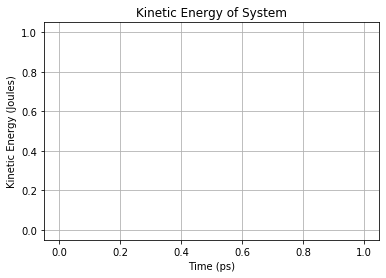

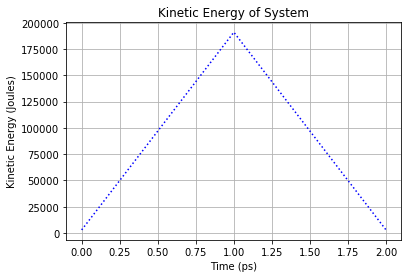

2 of 2 tests passed


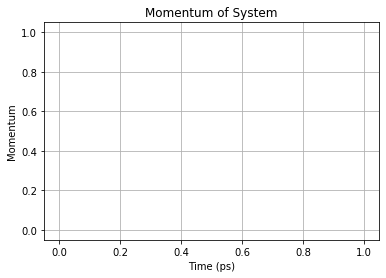

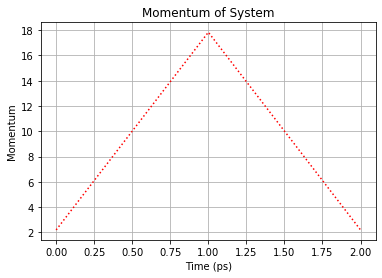

2 of 2 tests passed


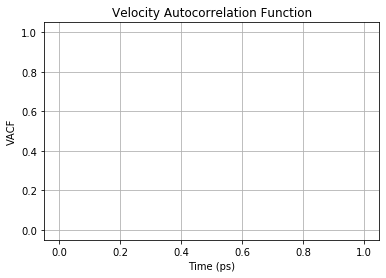

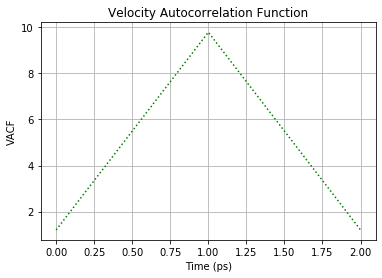

2 of 2 tests passed


In [13]:
# Function Testing
#Test List
generic_list = [Coord(0.0, 1, 1.2, 1.3, -1.3),
                 Coord(0.0, 2, 1.2, 1.3, -1.3),
                 Coord(0.0, 3, 1.2, 1.3, -1.3),
                 Coord(0.0, 4, 1.2, 1.3, -1.3),
                 Coord(1.0, 1, 10.3, 10.3, -10.3),
                 Coord(1.0, 2, 10.3, 10.3, -10.3),
                 Coord(1.0, 3, 10.3, 10.3, -10.3),
                 Coord(1.0, 4, 10.3, 10.3, -10.3),
                 Coord(2.0, 1, 1.2, 1.3, -1.3),
                 Coord(2.0, 2, 1.2, 1.3, -1.3),
                 Coord(2.0, 3, 1.2, 1.3, -1.3),
                 Coord(2.0, 4, 1.2, 1.3, -1.3)]


start_testing()
#testing axis titles, titles and grids
expect(make_kinetic_plot([], []), None)
#testing data plots
expect(make_kinetic_plot(get_time(generic_list), get_kinetic(generic_list)), None)
summary()

start_testing()
#testing axis titles, titles and grids
expect(make_momentum_plot([], []), None)
#testing data plots
expect(make_momentum_plot(get_time(generic_list), get_momentum(generic_list)), None)
summary()

start_testing()
#testing axis titles, titles and grids
expect(make_vacf_plot([], []), None)
#testing data plots
expect(make_vacf_plot(get_time(generic_list), get_vacf(generic_list, 1)), None)
summary()

## Here are some sketches of the expected graphs seen above.

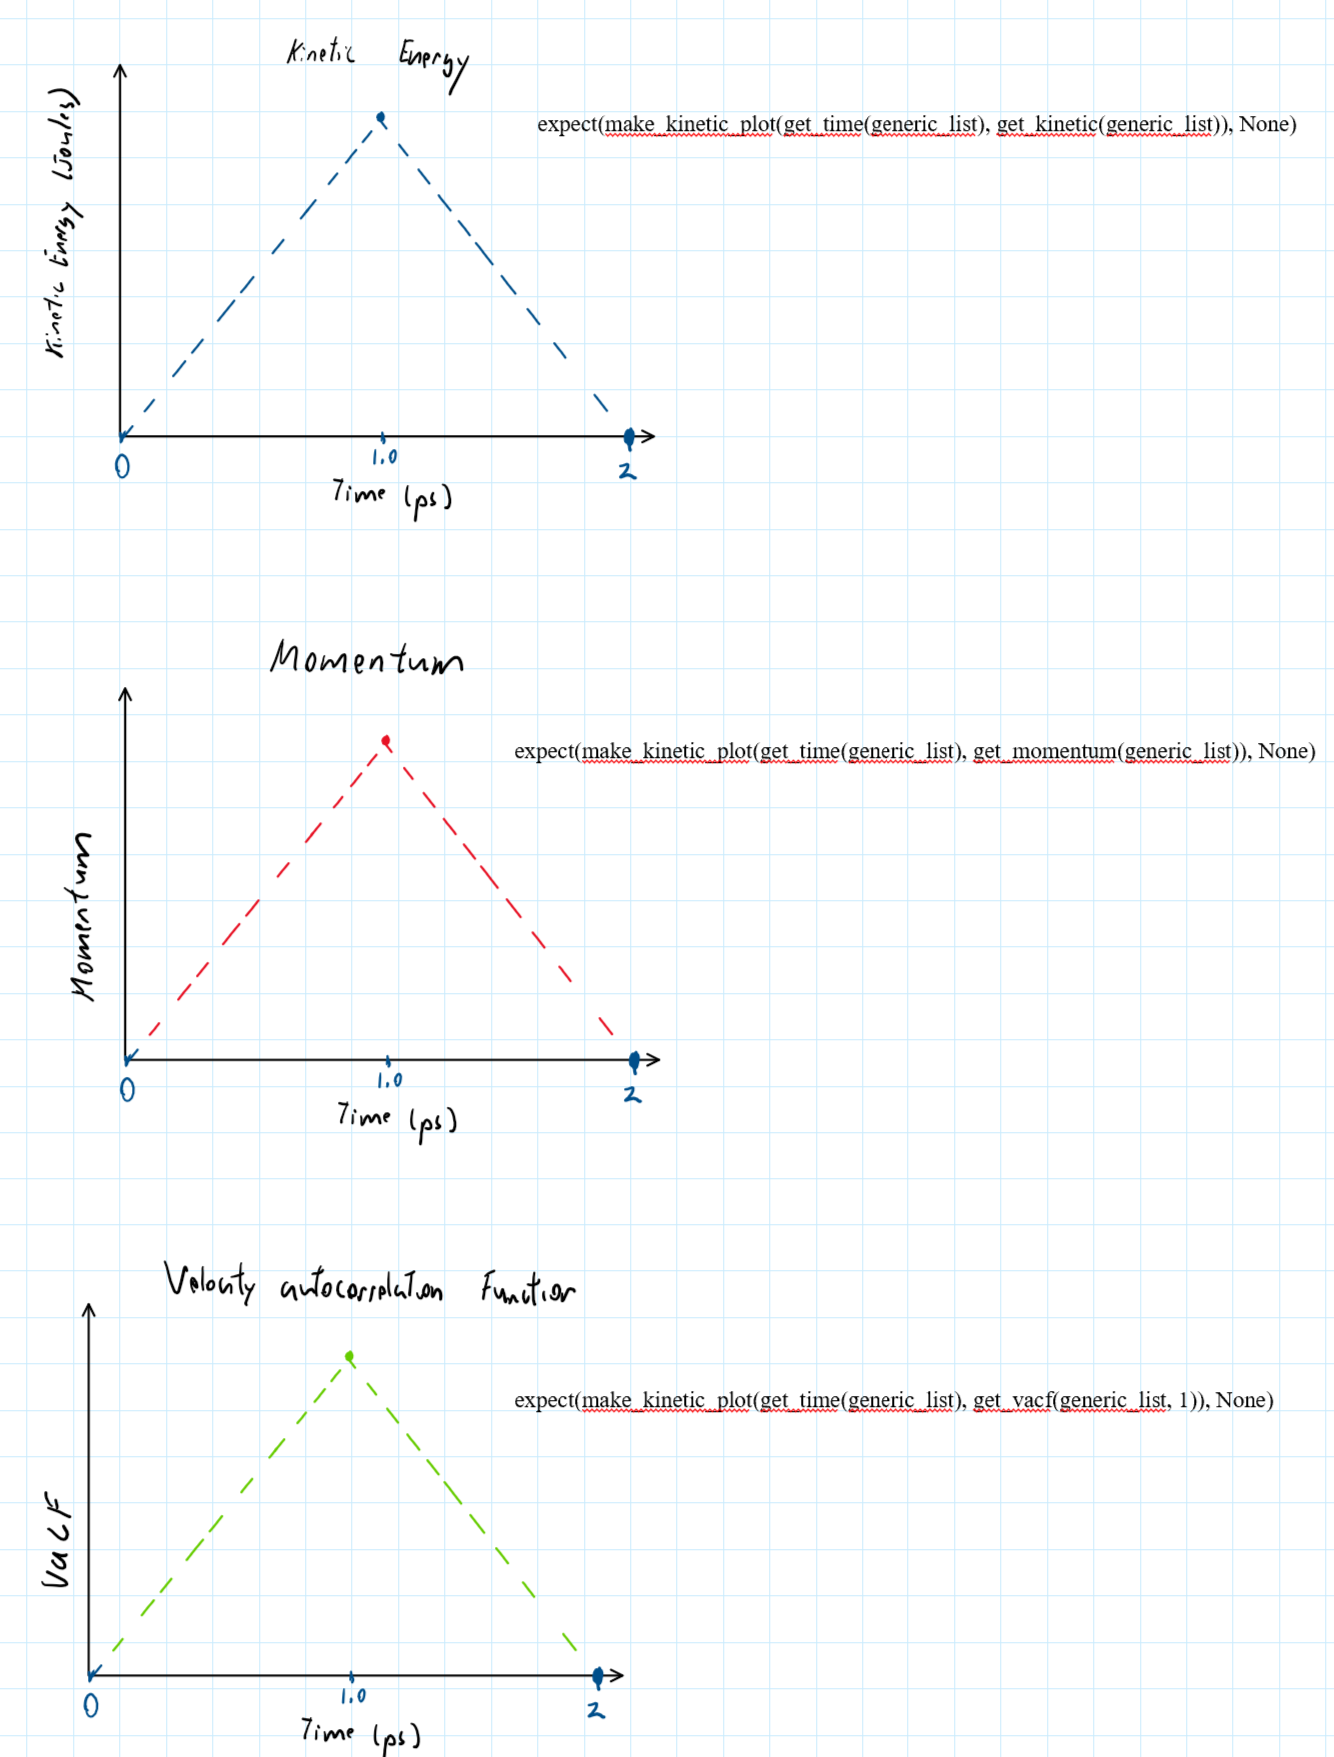

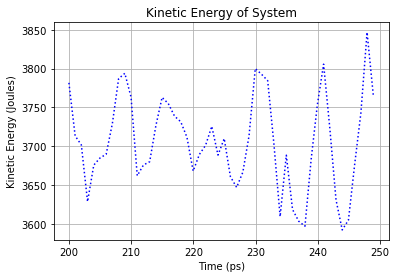

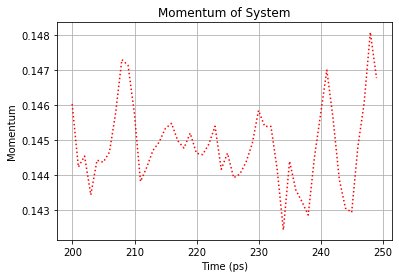

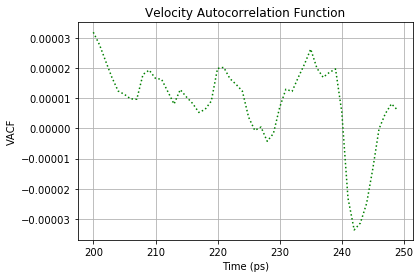

In [14]:
# FINAL FIGURES (TAKES A MINUTE TO RUN!)
make_plots(read('long.csv'))